### Llbraries

In [21]:
import os
import math
import ctypes
from ctypes import POINTER, pointer, byref, c_void_p, c_char, c_size_t, c_float, c_int, c_double

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

### visualization for C++ algorithm

In [22]:
libc = ctypes.CDLL("libc.so.6") 

libc.memmove.restype = c_void_p
libc.memmove.argtypes = [c_void_p, c_void_p, c_size_t]
libc.free.argtypes = [c_void_p]

! g++ -O3 -Wall -fPIC -shared mylib.cpp -o mylib.so
mylib = ctypes.cdll.LoadLibrary("./mylib.so")

In [23]:
def visualize(points, cells, plt):
    """
    Takes as input:
    1) coordinates of all the manipulator's initial points
    2) coordinates of the affected points

    Visualizes the set of points on the plane   
    """
    max_xy = cells.max(axis=0) + 2
    min_xy = cells.min(axis=0) - 2
    
    cells -= min_xy
    shape = max_xy - min_xy
    assert((cells >= 0).all())
    assert((cells < shape).all())

    image = np.zeros(shape=shape)
    image[cells[:, 0], cells[:, 1]] = 1

    plt.imshow(np.flip(image.transpose((1, 0)), axis=0), extent=[min_xy[0], max_xy[0], min_xy[1], max_xy[1]])

### functions which using C++ algorithm

In [24]:
mylib.get_state_cells.restype = c_size_t
mylib.get_state_cells.argtypes = [
    c_size_t, POINTER(c_double),
    POINTER(POINTER(c_int))
]
       
def get_state_cells(points):
    """
    Takes as input:
    1) Coordinates of all the manipulator's points

    Returns:
    2) Coordinates of all the cells occupied by it    
    """
    points = np.array(points, dtype=np.float64)
    points_count, _ = points.shape
    assert points.shape == (points_count, 2)

    points = points.flatten()
    cells_data = pointer(c_int())

    N = mylib.get_state_cells(
        points_count - 1, 
        points.ctypes.data_as(POINTER(c_double)),
        byref(cells_data)
    )

    cells = np.empty((2*N), dtype=np.int32)
    libc.memmove(cells.ctypes.data, cells_data, N*4*2)
    libc.free(cells_data)

    return cells.reshape((N, 2))


# Example
# points = [(0, 0), (100, 200), (-40, 300), (50, -20)]
# cells = get_state_cells(points)
# fig = plt.figure(figsize=(5, 5))
# visualize(points, cells, plt)

In [25]:
mylib.get_motion_cells.restype = c_size_t
mylib.get_motion_cells.argtypes = [
    c_size_t, POINTER(c_double),
    c_size_t, c_double,
    POINTER(POINTER(c_int))
]

def get_motion_cells(points, k, delta_arg):
    """
    Takes as input:
    1) Coordinates of all the manipulator's points
    2) The index of the vertex relative to which the rotation is performed (zero-indexed)
    3) Rotation angle (in radians)

    Returns:
    1) Coordinates of all the cells affected during the rotation process
    """
    points = np.array(points, dtype=np.float64)
    points_count, _ = points.shape
    assert points.shape == (points_count, 2)

    points = points.flatten()
    cells_data = pointer(c_int())

    N = mylib.get_motion_cells(
        points_count - 1, 
        points.ctypes.data_as(POINTER(c_double)),
        k, delta_arg,
        byref(cells_data)
    )

    cells = np.empty((2*N), dtype=np.int32)
    libc.memmove(cells.ctypes.data, cells_data, N*4*2)
    libc.free(cells_data)

    return cells.reshape((N, 2))

# Example 
# points = [(0, 0), (-100, 50), (100, 50)]
# cells = get_motion_cells(points, 0, -math.pi/2)
# fig = plt.figure(figsize=(5, 5))
# visualize(points, cells, plt)

In [26]:
def rotate_points_partial(points, k, delta_arg):
    """
    Rotates the points with indices > k around the k-th point by the angle delta_arg (in radians).

    Args:
        points (list of tuple): Original points.
        k (int): Index of the pivot point.
        delta_arg (float): Angle of rotation in radians.

    Returns:
        np.ndarray: Final points after selective rotation as an array of shape (n, 2).
    """
    points = np.array(points, dtype=np.float64)
    pivot = points[k]

    # Create rotation matrix
    cos_theta = math.cos(delta_arg)
    sin_theta = math.sin(delta_arg)
    rotation_matrix = np.array([[cos_theta, -sin_theta],
                                 [sin_theta, cos_theta]])

    # Points to be rotated (indices > k)
    rotated_part = np.dot(points[k + 1:] - pivot, rotation_matrix.T) + pivot

    # Combine unchanged and rotated points
    final_points = np.vstack((points[:k + 1], rotated_part))

    return final_points


# Example
# points = [(0, 0), (0, 50), (50, 50), (100, 100)]
# final_points = rotate_points_partial(points, 1, -math.pi / 2) 
# fig = plt.figure(figsize=(5, 5))
# visualize(get_state_cells(final_points), get_state_cells(final_points).astype(int), plt)


### function for presentation

In [27]:
def generate_animation(path, echelon_points, obstacles, n, output_dir="saved_frames"):
    # Create a directory for saving images if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Initialize lists for storing path positions and angles
    path_positions = []  # List of path points
    angle_tmp = []  # List of angles
    
    # Precompute the path positions based on the path and rotations
    for curr_node in path:
        curr_angles = curr_node.angles
        curr_pos = echelon_points
        for i, angle in enumerate(curr_angles):
            curr_pos = rotate_points_partial(curr_pos, i, angle * 2 * math.pi / n)
        path_positions.append(curr_pos)
        angle_tmp.append(curr_angles)

    # Create the figure and axes for visualization
    fig, ax = plt.subplots(figsize=(5, 5))

    # Visualize obstacles and path
    def visualize_animation(points, obstacles, plt):
        """
        Visualize the points and obstacles on a 2D plane.
        """
        plt.scatter(points[:, 0], points[:, 1], c='blue', label='Path Points', alpha=0.5)
        plt.scatter(obstacles[:, 0], obstacles[:, 1], c='red', label='Obstacles', alpha=0.5)
        plt.legend()

    # Update function for the animation
    def update(frame):
        # Clear the previous plot content
        ax.clear()
        
        # Get the current position from path_positions
        p = path_positions[frame]
        
        # Visualize the current path and obstacles
        visualize_animation(get_state_cells(p), np.array(obstacles).astype(int), plt)
        
        # Calculate the limits dynamically based on the path and obstacles
        all_points = np.concatenate([get_state_cells(p), obstacles])
        
        # Find the min/max of all the points to determine the bounds
        min_x, min_y = np.min(all_points, axis=0)
        max_x, max_y = np.max(all_points, axis=0)
        
        # Add some padding to the plot limits
        padding = 5
        ax.set_xlim(min_x - padding, max_x + padding)
        ax.set_ylim(min_y - padding, max_y + padding)

        # Save the current frame as an image file
        filename = os.path.join(output_dir, f"frame_{frame}.png")
        plt.savefig(filename)
        
        return ax,

    # Create the animation object (without displaying it, just saving frames)
    ani = FuncAnimation(
        fig, update, frames=len(path_positions), interval=1000, blit=False
    )

    # Add a callback to clear the figure after the animation ends
    def clear_after_animation(*args, **kwargs):
        plt.clf()  # Clear the entire figure
        plt.close(fig)  # Close the figure to prevent showing it

    # Display the animation and clear the last frame
    ani.event_source.stop()  # Stop the animation after it's done
    ani.event_source.add_callback(clear_after_animation)  # Call clear after animation ends

    # Display the animation in the Jupyter notebook
    animation_html = ani.to_jshtml()
    display(HTML(animation_html))  # Ensure this is called to display the animation

    return animation_html

### Examples

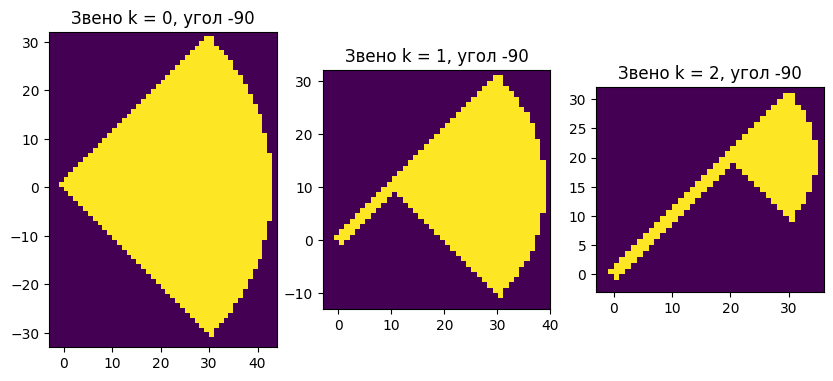

In [28]:
if __name__ == "__main__":
    points = [(0, 0), (10, 10), (20, 20), (30, 30)]
    cells_1 = get_motion_cells(points, 0, -math.pi/2)
    cells_2 = get_motion_cells(points, 1, -math.pi/2)
    cells_3 = get_motion_cells(points, 2, -math.pi/2)

    fig = plt.figure(figsize=(10, 7))

    plt.subplot(1, 3, 1)
    visualize(points, cells_1, plt)
    plt.title("Звено k = 0, угол -90") 

    plt.subplot(1, 3, 2)
    visualize(points, cells_2, plt) 
    plt.title("Звено k = 1, угол -90") 

    plt.subplot(1, 3, 3)
    visualize(points, cells_3, plt)
    plt.title("Звено k = 2, угол -90")   

    plt.show()

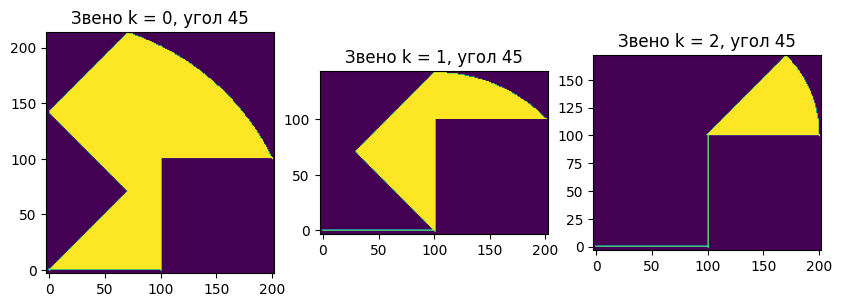

In [29]:
if __name__ == "__main__":
    points = [(0, 0), (100, 0), (100, 100), (200, 100)]
    cells_1 = get_motion_cells(points, 0, math.pi/4)
    cells_2 = get_motion_cells(points, 1, math.pi/4)
    cells_3 = get_motion_cells(points, 2, math.pi/4)

    fig = plt.figure(figsize=(10, 7))

    plt.subplot(1, 3, 1)
    visualize(points, cells_1, plt)
    plt.title("Звено k = 0, угол 45") 

    plt.subplot(1, 3, 2)
    visualize(points, cells_2, plt) 
    plt.title("Звено k = 1, угол 45") 

    plt.subplot(1, 3, 3)
    visualize(points, cells_3, plt)
    plt.title("Звено k = 2, угол 45")   

    plt.show()

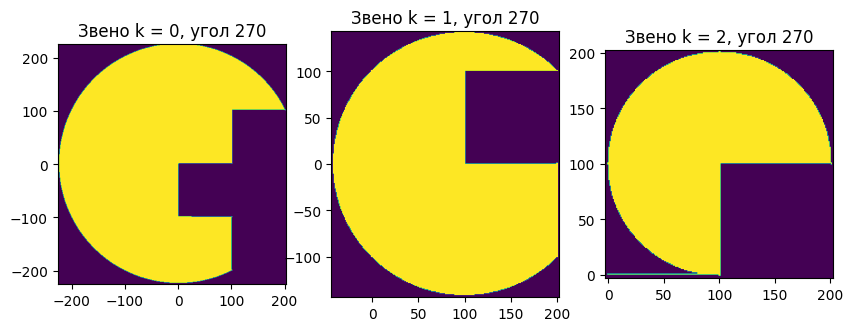

In [30]:
if __name__ == "__main__":
    points = [(0, 0), (100, 0), (100, 100), (200, 100)]
    cells_1 = get_motion_cells(points, 0, 3*math.pi/2)
    cells_2 = get_motion_cells(points, 1, 3*math.pi/2)
    cells_3 = get_motion_cells(points, 2, 3*math.pi/2)

    fig = plt.figure(figsize=(10, 7))

    plt.subplot(1, 3, 1)
    visualize(points, cells_1, plt)
    plt.title("Звено k = 0, угол 270") 

    plt.subplot(1, 3, 2)
    visualize(points, cells_2, plt) 
    plt.title("Звено k = 1, угол 270") 

    plt.subplot(1, 3, 3)
    visualize(points, cells_3, plt)
    plt.title("Звено k = 2, угол 270")   

    plt.show()

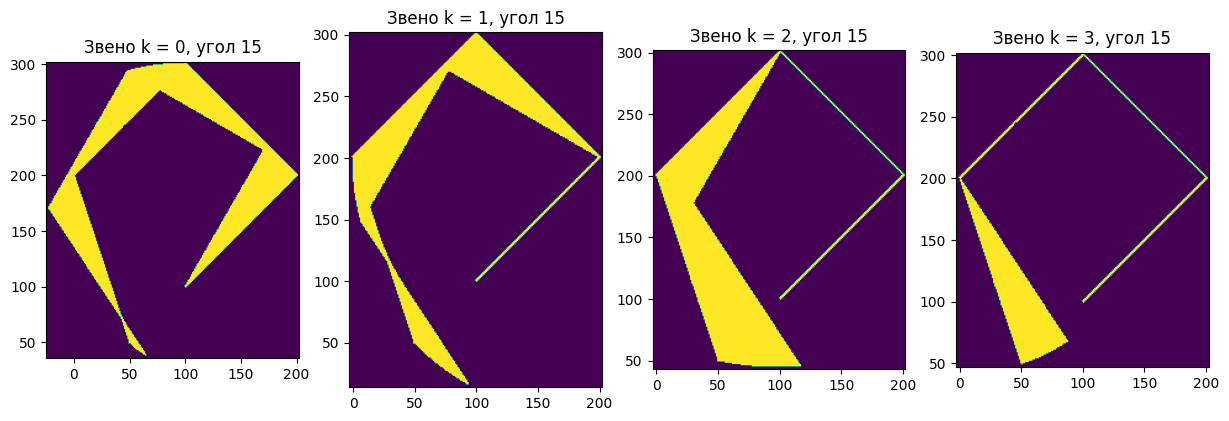

In [31]:
if __name__ == "__main__":
    points = [(100, 100), (200, 200), (100, 300), (0, 200), (50, 50)]
    cells_1 = get_motion_cells(points, 0, math.pi/12)
    cells_2 = get_motion_cells(points, 1, math.pi/12)
    cells_3 = get_motion_cells(points, 2, math.pi/12)
    cells_4 = get_motion_cells(points, 3, math.pi/12)

    fig = plt.figure(figsize=(15, 7))

    plt.subplot(1, 4, 1)
    visualize(points, cells_1, plt)
    plt.title("Звено k = 0, угол 15") 

    plt.subplot(1, 4, 2)
    visualize(points, cells_2, plt) 
    plt.title("Звено k = 1, угол 15") 

    plt.subplot(1, 4, 3)
    visualize(points, cells_3, plt)
    plt.title("Звено k = 2, угол 15")   

    plt.subplot(1, 4, 4)
    visualize(points, cells_4, plt)
    plt.title("Звено k = 3, угол 15")  

    plt.show()